# Vorversuch: Farbmodelle

## Fragestellung

Haben unterschiedliche Farbmodelle (RGB, HSV, L\*a\*b\*) einen Einfluss auf die Klassifikation von Objektfarben? Ziel: Bestmögliche Bottom-Up-Klassifikationsergebnisse in den darauffolgenden Versuchen.

## Hypothese/Vermutung

Es wird erwartet, dass unterschiedliche Farbmodelle zu leichten Variationen bei der Klassifikation führen. Es kann angenommen werden, dass HSV und L*a*b* zu leicht besseren Klassifikationsergebnissen führen. Dies würde sich einerseits mit den Ergebnissen von Van De Weijer et al. decken, andererseits sprechen aber auch Eigenschaften der einzelnen Farbmodelle für diese Annahme: Die Korrelation der einzelnen Farbkanäle ist bei der Graduierung von Farben in den Modellen HSV und L*a*b* geringer als bei RGB. Wird etwa ein Farbton abgedunkelt, so schlägt sich dies (in der Theorie) bei HSV und L*a*b* in den Helligkeitsparametern H bzw. I* nieder, während bei RGB potentiell alle Kanäle betroffen sind. Da bei der Unterscheidung zwischen Grundfarben insbesondere der Farbton (Parameter H bzw. a\*/b\*) von Bedeutung sind, würde ein Großteil der relvanten Variation zwischen Farben auf weniger Parameter entfallen als im RGB-Modell, was der Qualität der Klassifikation entgegen kommen könnte. Für das Farbmodell L*a*b* würde des weiteren sprechen, dass es sich dabei um ein wahrnehmungsbezogenes Modell handelt. Da Farbkategorien auf der menschlichen Klassifikation von Farbinformationen beruhen, könnte eine Klassifikation unter Zuhilfenahme eines perzeptuell orientierten Farbmodells zu verbesserten Ergebnissen führen.

## Versuchsaufbau / Material

Als Materialgrundlage dient ein Sample von 100 000 Einträgen aus dem vorverarbeiteten Visual-Genome-Datenset. Das Sample ist groß gewählt, um den Klassifikatoren im besten Fall zu ermöglichen auch von weniger frequenten oder klar abgegrenzten Farbwörtern kanonische Vertreter zu identifizieren.

Um den Einfluss der Farbmodelle auf die Klassifikation zu beschreiben, soll das Sample von identischen Klassifikatoren unter Variation des Farbraums klassifiziert werden. Die Ergebnisse sollen anhand gängiger Kriterien (Accuracy, Precision, Recall) verglichen werden.
Als Klassifikator dient in allen Fällen ein Perzeptron (nach Zarrieß/Schlangen 2016). 

Als Input für die Klassifikatoren dienen Histogramme, die mit OpenCV aus den Bildern extrahiert wurden. Für jede Bedingung (RGB, HSV, L*a*b*) wurden die Histogramme im jeweiligen Farbraum extrahiert. Zu diesem Zweck wurden für die Bedingungen HSV und L*a*b* die Bilder nach dem Import in OpenCV in das jeweilige Farbmodell transformiert. Der Output der Klassifikation ist für alle Bedingungen eine Wahrscheinlichkeitsverteilung über die 11 Grundfarbwörter für jedes Item.

## Durchführung

Die Klassifikatoren werden mit einem Trainings-Set von 70 000 Einheiten trainiert und auf einem Evaluationsset von 10 000 Einheiten getestet. Es werden die Parameter von Zarrieß & Schlangen 2016 übernommen. Die Klassifikatoren unterscheiden sich nicht zwischen den Bedigungen, ebensowenig wie die Auswahl der Versuchsitems.

## Beobachtete Ergebnisse

## Deutung

---

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import numpy as np
import os
import sys
import configparser
from collections import Counter
from pprint import pprint
from sklearn.metrics import classification_report

sys.path.append(os.path.abspath('../../Module'))
import preprocessing
import visualize
import evaluation

config = configparser.ConfigParser()
config.read('../../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']
input_dir = vg_json_export+'prediction_arrays/'

colors = preprocessing.basic_colors()

classifier_list = 'bgr hsv lab'.split()

set_type = 'test'

# Diagramme etc als Graustufen anzeigen. Verwendung: greyscale(labels), ergibt Liste von Farbwerten
greyscale = lambda x: plt.cm.gray(np.linspace(0.2,0.8,len(x)))

# Prediction-Arrays importieren + formatieren

In [2]:
# Gezippte Numpy-Archive importieren
#bgr_arrays = np.load(vg_json_export+'Kombination_bekannteKlassen/results_baseline_arrays.npz')
bgr_arrays = np.load(input_dir+'results_perceptron_bgr.npz')
hsv_arrays = np.load(input_dir+'results_perceptron_hsv.npz')
lab_arrays = np.load(input_dir+'results_perceptron_lab.npz')

# Prediction-Arrays aus importierten Numpy-Dateien
bgr_predict = bgr_arrays['predict_'+set_type+'_y']
hsv_predict = hsv_arrays['predict_'+set_type+'_y']
lab_predict = lab_arrays['predict_'+set_type+'_y']

# IDs zu Prediction-Arrays hinzufügen
ids = bgr_arrays[set_type+'_y'][:,0:1]
bgr_predict = np.append(ids, bgr_predict, axis=1)
ids = hsv_arrays[set_type+'_y'][:,0:1]
hsv_predict = np.append(ids, hsv_predict, axis=1)
ids = lab_arrays[set_type+'_y'][:,0:1]
lab_predict = np.append(ids, lab_predict, axis=1)

In [3]:
bgr_predict = pd.DataFrame(bgr_predict).sort_values(by=0).to_numpy()
hsv_predict = pd.DataFrame(hsv_predict).loc[pd.DataFrame(hsv_predict)[0].isin(bgr_predict[:,0].ravel())].sort_values(by=0).to_numpy()
lab_predict = pd.DataFrame(lab_predict).loc[pd.DataFrame(lab_predict)[0].isin(bgr_predict[:,0].ravel())].sort_values(by=0).to_numpy()
ids = hsv_predict[:,0].reshape(-1,1)
# Überprüfen, dass Shapes identisch sind
print ('Shapes identisch:',
       (bgr_predict.shape == hsv_predict.shape) and (bgr_predict.shape == lab_predict.shape),
       bgr_predict.shape)
# Überprüfen, dass IDs identisch sind
print ('IDs identisch:',(not False in (bgr_predict[:,0:1] == hsv_predict[:,0:1])) and (not False in (bgr_predict[:,0:1] == lab_predict[:,0:1])))

Shapes identisch: True (9053, 12)
IDs identisch: True


# DataFrames importieren + filtern

In [4]:
all_obj = pd.read_csv(vg_json_export+"extracted_data/all_objects.csv", index_col=0)
test_obj = pd.read_csv(vg_json_export+"extracted_data/"+set_type+"_df.csv", index_col=0)

# Frequente Objekte + CDOs + CNOs:
frequent_objects, color_diagnostic_objects, color_biased_objects, color_neutral_objects = preprocessing.freq_cdo_cno(all_obj, num_cdos=100, num_cnos=100, min_num=100)
# DataFrame mit Objekten aus Prediction-Arrays
pred_obj = all_obj.loc[bgr_predict[:,0]]
# DataFrames für CDOs, CBOs und CNOs
cd_obj = pred_obj.loc[pred_obj.object_name.isin(color_diagnostic_objects.keys())]
cb_obj = pred_obj.loc[pred_obj.object_name.isin(color_biased_objects)]
cn_obj = pred_obj.loc[pred_obj.object_name.isin(color_neutral_objects)]

print ('Anzahl Einträge in DataFrames:',dict(zip(('pred_obj','cd_obj','cb_obj','cn_obj'),(len(pred_obj),len(cd_obj),len(cb_obj),len(cn_obj)))))
#freq_obj, cd_obj, cn_obj, cb_obj = [df.loc[df.index.isin(ids.ravel())] for df in [freq_obj, cd_obj, cn_obj, cb_obj]]
#print ('Anzahl Einträge in reduzierten DataFrames:', dict(zip(('freq_obj','cd_obj','cb_obj','cn_obj'),(len(freq_obj),len(cd_obj),len(cb_obj),len(cn_obj)))))

# Überprüfen, ob prediction-Arrays gleich viele Einträge haben wie freq_obj
print ('Identische Indizes für Prediction-Arrays und DataFrame:', bgr_predict[:,0:1].ravel().astype(int).tolist() == pred_obj.index.tolist())

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Anzahl Einträge in DataFrames: {'pred_obj': 9053, 'cb_obj': 883, 'cn_obj': 1755, 'cd_obj': 1141}
Identische Indizes für Prediction-Arrays und DataFrame: True


# Prediction-Arrays und DataFrames zusammenführen

In [5]:
# DataFrames aus Predictions (np-Arrays) erstellen
bgr_predict_df =  pd.DataFrame(data=bgr_predict[0:,1:],index=bgr_predict[0:,0],columns=colors).sort_index().astype('float')
hsv_predict_df =  pd.DataFrame(data=hsv_predict[0:,1:],index=hsv_predict[0:,0],columns=colors).sort_index().astype('float')
lab_predict_df =  pd.DataFrame(data=lab_predict[0:,1:],index=lab_predict[0:,0],columns=colors).sort_index().astype('float')

# Farbwort mit höchstem Wert (-> prognostiziertes Farbwort) (ergibt pd.Series)
pred_label_bgr = bgr_predict_df.idxmax(axis=1)
pred_label_hsv = hsv_predict_df.idxmax(axis=1)
pred_label_lab = lab_predict_df.idxmax(axis=1)

# Predictions mit freq_obj kombinieren
predict_df = pred_obj.copy().sort_index()
predict_df = predict_df.merge(pred_label_bgr.rename('bgr_color'), left_index=True, right_index=True)
predict_df = predict_df.merge(pred_label_hsv.rename('hsv_color'), left_index=True, right_index=True)
predict_df = predict_df.merge(pred_label_lab.rename('lab_color'), left_index=True, right_index=True)

# DFs für CDOs, CNOs und CBOs
predict_cdo = predict_df.loc[cd_obj.index.to_list()]
predict_cbo = predict_df.loc[cb_obj.index.to_list()]
predict_cno = predict_df.loc[cn_obj.index.to_list()]

predict_df.head()

bb_h  bb_w  bb_x  bb_y  color  image_id  object_id       object_name  \
9.0     128    54   382   369   gray         1    1058531             pants   
68.0    102   372   425   132  brown         5    1060364           shelves   
206.0   121    42     1   335  white        12    1024188  computer monitor   
400.0   197   279   314     0  green        23    1024613              tree   
433.0   291   178   508   151  green        26    1061195         pine tree   

      bgr_color hsv_color lab_color  
9.0        gray     black     brown  
68.0      white     white     white  
206.0      pink    purple     white  
400.0     green     white     green  
433.0     brown     black     green

# widersprüchliche Farbinformationen entfernen

# Informationen zu Train- und Test/Dev-Sets

### Train

In [6]:
train_perceptron_arrays = np.load(vg_json_export+'feature_arrays/'+'/baseline_arrays_bgr_resampled.npz', allow_pickle=True)
train_items = train_perceptron_arrays['train_y'][:,1:].argmax(axis=1)
print ('Train-Items: {items}\nItems pro Klasse: {classes}'
       .format(items=len(train_items),classes=dict(Counter(train_items)))
      )

min_group = min(Counter(train_items))
max_group = max(Counter(train_items))

print ('Kleinste Gruppe: {small}, größte Gruppe: {large}'
       .format(
           small=(min_group, Counter(train_items)[min_group]), 
           large=(max_group, Counter(train_items)[max_group])
       ))

Train-Items: 110000
Items pro Klasse: {0: 10000, 1: 10000, 2: 10000, 3: 10000, 4: 10000, 5: 10000, 6: 10000, 7: 10000, 8: 10000, 9: 10000, 10: 10000}
Kleinste Gruppe: (0, 10000), größte Gruppe: (10, 10000)


### Test/Dev

# Evaluation

In [7]:
accuracy_scores = {} 
print ('Accuracy')
for classifier in classifier_list:
    accuracy_scores.update(evaluation.print_scores(classifier, column=classifier+'_color', df=predict_df, df_cdo=predict_cdo, df_cno=predict_cno, df_cbo=predict_cbo, return_dict = True, metric='accuracy'))
# accuracy_scores als LaTeX-Tabelle:
print (pd.DataFrame(accuracy_scores).T[['Alle Objekte', 'Color-Diagnostic Objects', 'Color-Biased Objects', 'Color-Neutral Objects']].round(decimals=3).to_latex())

f1_scores = {} 
print ('f1')
for classifier in classifier_list:
    f1_scores.update(evaluation.print_scores(classifier, column=classifier+'_color', df=predict_df, df_cdo=predict_cdo, df_cno=predict_cno, df_cbo=predict_cbo, return_dict = True, metric='f1', average='macro'))
# f1_scores als LaTeX-Tabelle:
print (pd.DataFrame(f1_scores).T[['Alle Objekte', 'Color-Diagnostic Objects', 'Color-Biased Objects', 'Color-Neutral Objects']].round(decimals=3).to_latex())

Accuracy
bgr:
Metric: accuracy
{'Alle Objekte': 0.44250524687948745}
{'Color-Diagnostic Objects': 0.530236634531113}
{'Color-Biased Objects': 0.3827859569648924}
{'Color-Neutral Objects': 0.49173789173789173}


hsv:
Metric: accuracy
{'Alle Objekte': 0.4083729150557826}
{'Color-Diagnostic Objects': 0.5451358457493427}
{'Color-Biased Objects': 0.3363533408833522}
{'Color-Neutral Objects': 0.46609686609686607}


lab:
Metric: accuracy
{'Alle Objekte': 0.3789903899259914}
{'Color-Diagnostic Objects': 0.49693251533742333}
{'Color-Biased Objects': 0.3272933182332956}
{'Color-Neutral Objects': 0.4205128205128205}


\begin{tabular}{lrrrr}
\toprule
{} &  Alle Objekte &  Color-Diagnostic Objects &  Color-Biased Objects &  Color-Neutral Objects \\
\midrule
bgr &         0.443 &                     0.530 &                 0.383 &                  0.492 \\
hsv &         0.408 &                     0.545 &                 0.336 &                  0.466 \\
lab &         0.379 &                     0.4

## Alle Objekte

In [27]:
for classifier in classifier_list:
    print (classifier)
    print (classification_report(predict_df['color'], predict_df[classifier+'_color']))
    columns = [c for c in colors]
    columns.append('macro avg')
    report = pd.DataFrame(classification_report(predict_df['color'], predict_df[classifier+'_color'], output_dict=True))\
        .drop(['support'], axis=0).drop(['weighted avg'], axis=1)\
        [columns]\
        .T[['precision', 'recall', 'f1-score']].round(decimals=3)\
    # LaTeX
    print (report.to_latex())

bgr
              precision    recall  f1-score   support

       black       0.38      0.44      0.41       823
        blue       0.50      0.50      0.50       823
       brown       0.38      0.38      0.38       823
        gray       0.37      0.27      0.31       823
       green       0.49      0.56      0.52       823
      orange       0.43      0.46      0.44       823
        pink       0.53      0.49      0.51       823
      purple       0.62      0.46      0.53       823
         red       0.37      0.61      0.46       823
       white       0.34      0.15      0.21       823
      yellow       0.49      0.54      0.51       823

   micro avg       0.44      0.44      0.44      9053
   macro avg       0.44      0.44      0.44      9053
weighted avg       0.44      0.44      0.44      9053

\begin{tabular}{lrrr}
\toprule
{} &  precision &  recall &  f1-score \\
\midrule
black     &      0.384 &   0.439 &     0.409 \\
blue      &      0.501 &   0.501 &     0.501 \\
brown 

In [9]:
bgr_report = pd.DataFrame(classification_report(predict_df['color'], predict_df['bgr'+'_color'], output_dict=True))[colors].T
bgr_report['prec-rec-diff'] = bgr_report.apply(lambda x: x.precision - x.recall, axis=1)
bgr_report['prec-rec-diff_abs'] = bgr_report.apply(lambda x: abs(x.precision - x.recall), axis=1)

hsv_report = pd.DataFrame(classification_report(predict_df['color'], predict_df['hsv'+'_color'], output_dict=True))[colors].T
hsv_report['prec-rec-diff'] = hsv_report.apply(lambda x: x.precision - x.recall, axis=1)
hsv_report['prec-rec-diff_abs'] = hsv_report.apply(lambda x: abs(x.precision - x.recall), axis=1)

lab_report = pd.DataFrame(classification_report(predict_df['color'], predict_df['lab'+'_color'], output_dict=True))[colors].T
lab_report['prec-rec-diff'] = lab_report.apply(lambda x: x.precision - x.recall, axis=1)
lab_report['prec-rec-diff_abs'] = lab_report.apply(lambda x: abs(x.precision - x.recall), axis=1)

In [10]:
metric = 'f1-score'

In [11]:
bgr_report.sort_values(by=metric)

f1-score  precision    recall  support  prec-rec-diff  \
white   0.208754   0.339726  0.150668    823.0       0.189058   
gray    0.311978   0.365416  0.272175    823.0       0.093241   
brown   0.381412   0.378897  0.383961    823.0      -0.005064   
black   0.409297   0.383634  0.438639    823.0      -0.055005   
orange  0.442353   0.428734  0.456865    823.0      -0.028131   
red     0.458371   0.367572  0.608748    823.0      -0.241177   
blue    0.500608   0.500608  0.500608    823.0       0.000000   
pink    0.509114   0.527344  0.492102    823.0       0.035242   
yellow  0.511870   0.488938  0.537060    823.0      -0.048121   
green   0.521984   0.486856  0.562576    823.0      -0.075720   
purple  0.531663   0.622150  0.464156    823.0       0.157994   

        prec-rec-diff_abs  
white            0.189058  
gray             0.093241  
brown            0.005064  
black            0.055005  
orange           0.028131  
red              0.241177  
blue             0.000000  
pink             0.035242  
yellow           0.048121  
green            0.075720  
purple           0.157994

In [12]:
#bgr_report.describe()

In [13]:
hsv_report.sort_values(by=metric)


f1-score  precision    recall  support  prec-rec-diff  \
white   0.185022   0.336538  0.127582    823.0       0.208956   
gray    0.291233   0.374761  0.238153    823.0       0.136608   
red     0.324067   0.467890  0.247874    823.0       0.220016   
brown   0.395362   0.378049  0.414338    823.0      -0.036289   
yellow  0.398545   0.496377  0.332928    823.0       0.163449   
black   0.399050   0.390244  0.408262    823.0      -0.018019   
green   0.415066   0.300764  0.669502    823.0      -0.368738   
orange  0.435391   0.457219  0.415553    823.0       0.041666   
pink    0.481460   0.466895  0.496962    823.0      -0.030067   
blue    0.500273   0.454365  0.556501    823.0      -0.102136   
purple  0.526835   0.479561  0.584447    823.0      -0.104886   

        prec-rec-diff_abs  
white            0.208956  
gray             0.136608  
red              0.220016  
brown            0.036289  
yellow           0.163449  
black            0.018019  
green            0.368738  
orange           0.041666  
pink             0.030067  
blue             0.102136  
purple           0.104886

In [14]:
#hsv_report.describe()

In [15]:
lab_report.sort_values(by=metric)

f1-score  precision    recall  support  prec-rec-diff  \
gray    0.151724   0.261128  0.106926    823.0       0.154202   
white   0.229124   0.265176  0.201701    823.0       0.063475   
black   0.347247   0.345783  0.348724    823.0      -0.002941   
brown   0.359670   0.349370  0.370595    823.0      -0.021225   
pink    0.373591   0.553699  0.281896    823.0       0.271804   
purple  0.383402   0.604712  0.280680    823.0       0.324032   
orange  0.406161   0.304745  0.608748    823.0      -0.304004   
red     0.416979   0.428755  0.405832    823.0       0.022922   
blue    0.426716   0.345086  0.558931    823.0      -0.213844   
yellow  0.467334   0.453196  0.482382    823.0      -0.029185   
green   0.483962   0.450734  0.522479    823.0      -0.071745   

        prec-rec-diff_abs  
gray             0.154202  
white            0.063475  
black            0.002941  
brown            0.021225  
pink             0.271804  
purple           0.324032  
orange           0.304004  
red              0.022922  
blue             0.213844  
yellow           0.029185  
green            0.071745

In [16]:
#lab_report.describe()

## CDOs

In [17]:
for classifier in classifier_list:
    print (classifier)
    print (classification_report(predict_cdo['color'], predict_cdo[classifier+'_color']))
    # LaTeX
    #print (pd.DataFrame(classification_report(predict_df['color'], predict_df[classifier+'_color'], output_dict=True)).T.to_latex())

bgr
              precision    recall  f1-score   support

       black       0.29      0.40      0.33        45
        blue       0.63      0.65      0.64       233
       brown       0.27      0.29      0.28        73
        gray       0.35      0.40      0.37        85
       green       0.78      0.64      0.70       366
      orange       0.48      0.69      0.57        70
        pink       0.29      0.35      0.32        17
      purple       0.26      0.26      0.26        27
         red       0.34      0.59      0.43        27
       white       0.48      0.30      0.37       159
      yellow       0.33      0.54      0.41        39

   micro avg       0.53      0.53      0.53      1141
   macro avg       0.41      0.46      0.43      1141
weighted avg       0.56      0.53      0.54      1141

hsv
              precision    recall  f1-score   support

       black       0.30      0.38      0.34        45
        blue       0.59      0.69      0.64       233
       brown    

## CBOs

In [18]:
for classifier in classifier_list:
    print (classifier)
    print (classification_report(predict_cbo['color'], predict_cbo[classifier+'_color']))
    # LaTeX
    #print (pd.DataFrame(classification_report(predict_df['color'], predict_df[classifier+'_color'], output_dict=True)).T.to_latex())

bgr
              precision    recall  f1-score   support

       black       0.43      0.43      0.43       124
        blue       0.34      0.38      0.36        58
       brown       0.40      0.39      0.40        88
        gray       0.27      0.19      0.23        73
       green       0.35      0.46      0.40        52
      orange       0.31      0.31      0.31        77
        pink       0.48      0.45      0.47        89
      purple       0.60      0.40      0.48        73
         red       0.32      0.63      0.43        78
       white       0.30      0.11      0.16        99
      yellow       0.40      0.53      0.46        72

   micro avg       0.38      0.38      0.38       883
   macro avg       0.38      0.39      0.37       883
weighted avg       0.39      0.38      0.37       883

hsv
              precision    recall  f1-score   support

       black       0.36      0.32      0.34       124
        blue       0.29      0.47      0.36        58
       brown    

## CNOs

In [19]:
for classifier in classifier_list:
    print (classifier)
    print (classification_report(predict_cno['color'], predict_cno[classifier+'_color']))
    # LaTeX
    #print (pd.DataFrame(classification_report(predict_df['color'], predict_df[classifier+'_color'], output_dict=True)).T.to_latex())

bgr
              precision    recall  f1-score   support

       black       0.38      0.51      0.44       132
        blue       0.53      0.51      0.52       177
       brown       0.35      0.42      0.38       106
        gray       0.42      0.21      0.28       157
       green       0.38      0.51      0.43        87
      orange       0.47      0.42      0.45       172
        pink       0.66      0.58      0.62       256
      purple       0.75      0.58      0.65       267
         red       0.39      0.65      0.49       185
       white       0.29      0.15      0.20        91
      yellow       0.50      0.58      0.54       125

   micro avg       0.49      0.49      0.49      1755
   macro avg       0.47      0.47      0.45      1755
weighted avg       0.51      0.49      0.49      1755

hsv
              precision    recall  f1-score   support

       black       0.42      0.52      0.46       132
        blue       0.45      0.53      0.49       177
       brown    

## Mean Reciprocal Rank (alle Objekte)

In [20]:
# Werte von 0 bis 1, bester Wert 1
for classifier in classifier_list:
    print (classifier)
    print (round(
        evaluation.get_label_ranking_average_precision_score(pd.get_dummies(predict_df.color), eval(classifier+'_predict_df')),3
    ))
    print ('\n')

bgr
0.616


hsv
0.593


lab
0.568




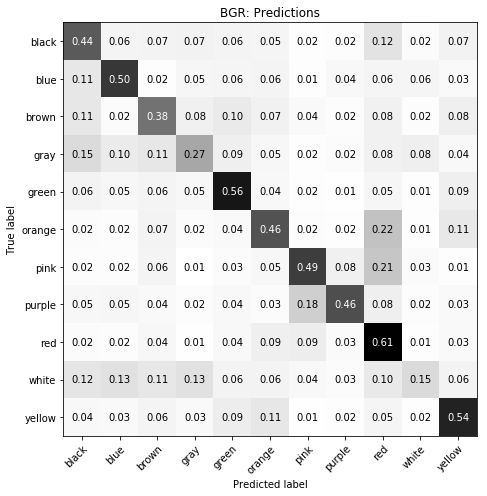

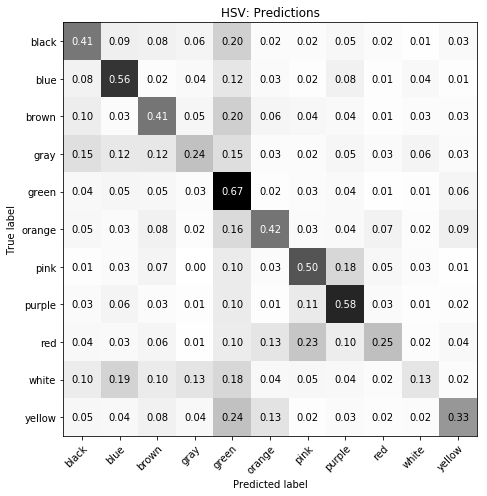

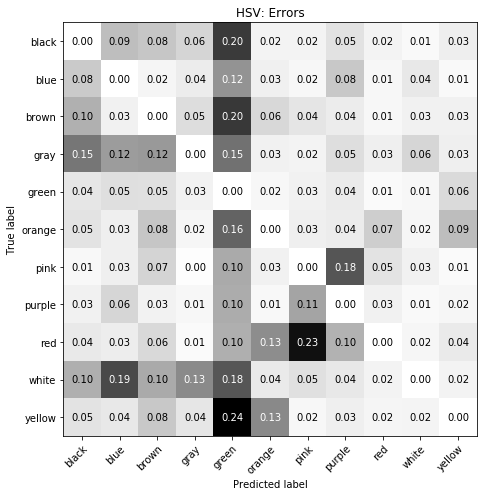

In [21]:
df = predict_df
save = True

for classifier in classifier_list:
    evaluation.plot_confusion_matrix(df['color'], df[classifier+'_color'], classes=colors, normalize=True, title=classifier.upper() + ': Predictions', error_matrix=False, cmap=plt.cm.Greys, colorbar=False, save_image=save, file_dir = vg_json_export+'images/')
    evaluation.plot_confusion_matrix(df['color'], df[classifier+'_color'], classes=colors, normalize=True, title=classifier.upper() + ': Errors', error_matrix=True, cmap=plt.cm.Greys, colorbar=False, save_image=save, file_dir = vg_json_export+'images/')